# Unit 5 - Financial Planning

In [2]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
from pathlib import Path
import datetime

%matplotlib inline

In [4]:
# Load .env enviroment variables, allow user to define path or use .env in current dir
env_path = Path('/Users/stuartperry/Env_files/API_keys/Alpaca.env')
if os.path.exists(env_path):
    print (f'Using .env file in path {env_path}')
    load_dotenv(dotenv_path=env_path)
else:
    print ('Using local .env file')
    load_dotenv()

Using .env file in path /Users/stuartperry/Env_files/API_keys/Alpaca.env


In [5]:
# set constants for API keys, check type.
ALPACA_API_KEY = os.getenv('ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.getenv('ALPACA_SECRET_KEY')
type(ALPACA_API_KEY), type(ALPACA_SECRET_KEY)

(str, str)

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [6]:
# Set current amount of crypto assets
crypto_holdings = {
    'BTC':1.2,
    'ETH':5.3
}

In [7]:
# Crypto API URLs (maybe convert to AUD later on?)
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [8]:
# Function to get price 
def get_price(url):
    '''
    Takes alternative API url pointing to a ticker. Returns the price of the cryptocurrency in CAD.

    json object structure: data (dict) > id (dict) > quotes (dict) > currency (dict) > price (key)

    url (str) = URL pointing to cryptocurrency ticker
    
    '''
    # access API and store as json
    response = requests.get(url).json()

    # get price, assuming the unique id is always the first element in the 'data' object
    price = list(response['data'].values())[0]['quotes']['CAD']['price']
    return price


In [11]:
# Fetch current BTC price
btc_price = get_price(btc_url)

# Fetch current ETH price
eth_price = get_price(eth_url)

# Compute current value of my crypto
crypto_value = {
    'BTC_value' : crypto_holdings['BTC']*btc_price,
    'ETH_value' : crypto_holdings['ETH']*eth_price
}
# Print current crypto wallet balance
print(f"The current value of your {crypto_holdings['BTC']} BTC is ${crypto_value['BTC_value']:0.2f} CAD")
print(f"The current value of your {crypto_holdings['ETH']} ETH is ${crypto_value['ETH_value']:0.2f} CAD")

The current value of your 1.2 BTC is $62620.35 CAD
The current value of your 5.3 ETH is $19168.23 CAD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [12]:
# Set current amount of shares
share_folio = {
    'AGG' : 200,
    'SPY' : 50
}

In [13]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    ALPACA_API_KEY,
    ALPACA_SECRET_KEY,
    api_version="v2")

In [56]:
# create function for api call, due to the get_barset function being depreciated, get_bars was used.
# this function returns data in a different form so additional data wrangling was nessecary.
def ticker_data (ticker, start = 1500):
    '''
    Uses the alpaca.get_bars function to obtain historical data about a stock ticker,

    slices API response and returns a Dataframe with datetime index.

    ticker (str) = stock ticker of interest

    start (int) =  neumerical value describing amount of historical data to collect (weekends/public holidays included).
    '''

    # Use two days ago because time difference for AUS can cause response errors based on the time of day.
    # Set end date to yesterdays date using EST timezone.
    end_date = (pd.to_datetime('today', utc = True).tz_convert('EST') - pd.DateOffset(1)).isoformat()

    # Set start date (default = 1501, approx 1000 trading days)
    start_date = (pd.to_datetime('today', utc = True).tz_convert('EST') - pd.DateOffset(1+start)).isoformat()

    # Call API, pass in ticker argument, set timeframe to Day and set time period.
    data = alpaca.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df

    # slice columns
    data = data.drop(['trade_count', 'vwap', 'volume'], axis='columns')

    return data

In [61]:
# Because the later section uses historical data, get and store 5 years of data 
# and access the last element for portfolio calaulcations
five_years = 365*5

# call function for each ticker
spy = ticker_data('SPY', five_years)
agg = ticker_data('AGG', five_years)

# concatenate the ticker data and set keys for multi-indexing along columns
stock_data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')

# drop nan, sort data. 
stocks = stock_data.dropna().sort_index(ascending=True)

# Preview DataFrame
stock_data


SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
2017-03-28 04:00:00+00:00  233.290  235.81  233.14  235.260  108.63  108.680   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
2017-03-28 04:00:00+00:00  108.3500  108.37  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1258 rows x 8 columns]

In [62]:
# Pick most recent AGG and SPY close prices
agg_close = stocks['AGG', 'close'][-1]
spy_close = stocks['SPY', 'close'][-1]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close}")
print(f"Current SPY closing price: ${spy_close}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [63]:
# Compute the current value of shares
share_value = {
    'AGG_value' : share_folio['AGG']*agg_close,
    'SPY_value' : share_folio['SPY']*spy_close
}

# Print current value of shares
print(f"The current value of your {share_folio['SPY']} SPY shares is ${share_value['SPY_value']:0.2f}")
print(f"The current value of your {share_folio['AGG']} AGG shares is ${share_value['AGG_value']:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


### Savings Health Analysis

In [64]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = sum(crypto_value.values())
shares = sum(share_value.values())

# Create savings DataFrame, pass in data, transpose and rename column.
df_savings = pd.DataFrame({'crypto':[crypto], 'shares':[shares]}).T.rename(columns={0:'amount'})

# Display savings DataFrame
df_savings

,amount
crypto,81788.580454
shares,43846.000000


array([<AxesSubplot:ylabel='amount'>], dtype=object)

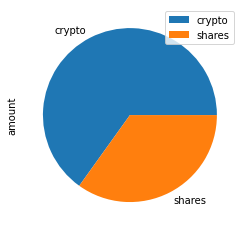

In [65]:
# Plot savings pie chart
df_savings.plot(kind='pie', subplots=True)

In [66]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
savings = df_savings['amount'].sum()

# Validate saving health
if savings > emergency_fund:
    print (f'Congratulations, your total savings of {savings:0.2f} should cover you in an emergency.')
elif savings == emergency_fund:
    print (f'Congratulations, you have reached your goal of {savings:0.2f} for an emergency fund!')
else:
    print (f'Your emergency fund is {(emergency_fund-savings):0.2f} away from your goal of {emergency_fund:0.2f}. Keep going!')

Congratulations, your total savings of 125634.58 should cover you in an emergency.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [67]:
#confirm the data is still in the form that is needed for MC simulations
stock_data

SPY                              AGG           \
                              open    high     low    close    open     high   
timestamp                                                                      
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250  108.44  108.540   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940  108.44  108.510   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880  108.35  108.510   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575  108.65  108.710   
2017-03-28 04:00:00+00:00  233.290  235.81  233.14  235.260  108.63  108.680   
...                            ...     ...     ...      ...     ...      ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000  107.78  107.816   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170  107.83  107.920   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620  107.63  107.730   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070  107.87  108.060   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520  107.95  108.140   

                                             
                                low   close  
timestamp                                    
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36  
2017-03-27 04:00:00+00:00  108.5345  108.62  
2017-03-28 04:00:00+00:00  108.3500  108.37  
...                             ...     ...  
2022-03-14 04:00:00+00:00  107.3600  107.36  
2022-03-15 04:00:00+00:00  107.4300  107.60  
2022-03-16 04:00:00+00:00  107.0032  107.68  
2022-03-17 04:00:00+00:00  107.7300  107.86  
2022-03-18 04:00:00+00:00  107.9203  108.10  

[1258 rows x 8 columns]

In [68]:
# Configure a Monte Carlo simulation to forecast 30 years cumulative returns
weights = {
    'SPY':0.6,
    'AGG':0.4
}
# initilize monte carlo simulation, assuming weights match the dataset. Forecasted trading days is 30 years (252 * 30)
mc_sim = MCSimulation(
    portfolio_data = stock_data,
    weights=list(weights.values()),
    num_simulation=500,
    num_trading_days=252*30
    )

In [69]:
# Print the simulation input data, verify that MCForecastTools has calculated daily returns
mc_sim.portfolio_data

SPY                                        \
                              open    high     low    close daily_return   
timestamp                                                                  
2017-03-22 04:00:00+00:00  233.780  234.61  233.05  234.250          NaN   
2017-03-23 04:00:00+00:00  234.010  235.34  233.60  233.940    -0.001323   
2017-03-24 04:00:00+00:00  234.350  235.04  232.96  233.880    -0.000256   
2017-03-27 04:00:00+00:00  231.970  233.92  231.61  233.575    -0.001304   
2017-03-28 04:00:00+00:00  233.290  235.81  233.14  235.260     0.007214   
...                            ...     ...     ...      ...          ...   
2022-03-14 04:00:00+00:00  420.975  424.55  415.79  417.000    -0.007308   
2022-03-15 04:00:00+00:00  419.900  426.84  418.42  426.170     0.021990   
2022-03-16 04:00:00+00:00  429.940  435.68  424.80  435.620     0.022174   
2022-03-17 04:00:00+00:00  433.700  441.07  433.19  441.070     0.012511   
2022-03-18 04:00:00+00:00  438.200  444.86  437.22  444.520     0.007822   

                              AGG                                          
                             open     high       low   close daily_return  
timestamp                                                                  
2017-03-22 04:00:00+00:00  108.44  108.540  108.3600  108.42          NaN  
2017-03-23 04:00:00+00:00  108.44  108.510  108.2635  108.45     0.000277  
2017-03-24 04:00:00+00:00  108.35  108.510  108.3100  108.36    -0.000830  
2017-03-27 04:00:00+00:00  108.65  108.710  108.5345  108.62     0.002399  
2017-03-28 04:00:00+00:00  108.63  108.680  108.3500  108.37    -0.002302  
...                           ...      ...       ...     ...          ...  
2022-03-14 04:00:00+00:00  107.78  107.816  107.3600  107.36    -0.009685  
2022-03-15 04:00:00+00:00  107.83  107.920  107.4300  107.60     0.002235  
2022-03-16 04:00:00+00:00  107.63  107.730  107.0032  107.68     0.000743  
2022-03-17 04:00:00+00:00  107.87  108.060  107.7300  107.86     0.001672  
2022-03-18 04:00:00+00:00  107.95  108.140  107.9203  108.10     0.002225  

[1258 rows x 10 columns]

In [70]:
# Run a Monte Carlo simulation to forecast 30 years cumulative returns
mc_sim.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Unit-5-homework/Instructions/Starter_Code/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992597,1.006544,0.997796,0.999442,1.001018,1.011549,1.012548,0.992389,1.001319,0.998730,...,1.003183,0.987322,0.995165,0.995587,0.996116,1.004306,1.000373,0.994518,1.002178,0.993473
2,1.001494,0.998385,1.005787,1.012980,1.001041,1.015223,1.006204,0.990669,0.991794,0.987091,...,1.012860,0.991319,0.995323,0.983808,0.998529,1.002053,0.992448,0.993230,1.003928,0.985527
3,0.998962,1.003766,1.013308,1.006429,1.011613,1.004593,0.987148,0.993310,0.998613,0.987327,...,1.016234,1.001122,0.999404,0.971705,0.990576,1.006932,0.996303,0.985997,1.013906,0.991997
4,0.995339,0.992481,1.000243,1.007347,1.012729,1.009107,1.000434,0.993673,0.992360,1.001574,...,1.022420,1.019016,0.996627,0.973785,0.995060,1.013590,1.002530,0.990884,1.006933,0.990892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,3.785154,16.543073,15.515107,32.782913,5.781340,4.694429,12.521802,10.355268,13.522666,11.090865,...,10.213826,24.775083,17.190044,14.371953,5.843323,6.325382,14.791414,20.765211,18.054276,9.474154
7557,3.769879,16.393883,15.272977,32.765806,5.749419,4.677902,12.502135,10.343982,13.671879,11.118006,...,10.337201,24.658300,17.511116,14.543759,5.815654,6.344334,14.826873,20.889098,18.077425,9.389609
7558,3.747608,16.365687,15.301155,32.858152,5.758656,4.686496,12.474155,10.508036,13.589197,11.177846,...,10.369866,24.726648,17.557288,14.605905,5.774535,6.319123,14.761769,21.051614,18.223868,9.446859
7559,3.741446,16.344591,15.229785,33.009079,5.796529,4.649965,12.386769,10.379687,13.612666,11.288154,...,10.400497,24.545813,17.393115,14.556230,5.746647,6.303916,14.665758,21.180121,18.137943,9.429358


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

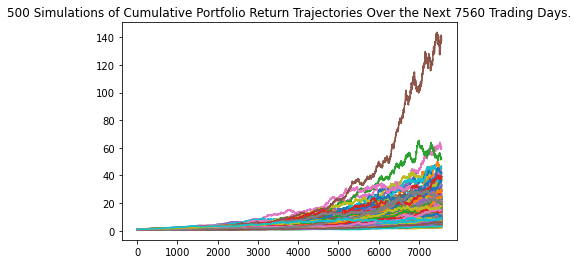

In [71]:
# Plot simulation outcomes
mc_sim.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

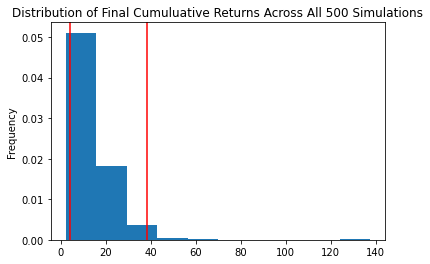

In [72]:
# Plot probability distribution and confidence intervals
mc_sim.plot_distribution()

### Retirement Analysis

In [73]:
# Fetch summary statistics from the Monte Carlo simulation results
summary = mc_sim.summarize_cumulative_return()

# Print summary statistics
summary

count           500.000000
mean             13.819648
std              10.251698
min               2.117953
25%               7.320296
50%              11.343704
75%              17.184332
max             137.589800
95% CI Lower      3.768260
95% CI Upper     38.442222
Name: 7560, dtype: float64

### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [74]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $75365.19 and $768844.44


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [75]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
lower = initial_investment*summary['95% CI Lower']
upper = initial_investment*summary['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower:0.2f} and ${upper:0.2f}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $113047.79 and $1153266.65


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [20]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5 = MCSimulation(portfolio_data = stock_data, weights=list(weights.values()), num_simulation=500, num_trading_days=252*5)

In [21]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_sim_5.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Unit-5-homework/Instructions/Starter_Code/MCForecastTools.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002534,1.005858,1.000242,1.007757,1.002946,0.998647,1.001909,0.995129,1.004731,1.013237,...,1.004435,0.990029,1.000061,1.001566,0.989814,0.989856,0.993687,0.998156,1.004471,1.000241
2,0.999276,1.004613,1.002494,1.001838,1.008694,0.995702,1.004971,0.985407,1.009610,1.021075,...,1.012557,0.989432,0.998636,0.989351,0.979267,0.993728,1.003234,1.002346,0.997220,1.005593
3,1.002550,1.007588,1.010319,1.006753,1.002237,0.999373,1.000979,0.985123,1.002581,1.022593,...,1.015077,0.992858,0.993679,0.983068,0.976623,0.994162,1.000522,0.998868,1.006147,1.006566
4,1.002144,1.002458,1.011178,1.000762,1.000116,0.998049,1.000513,0.993119,1.006312,1.026214,...,1.015005,0.996045,1.004351,0.976665,0.983024,0.996130,1.013535,1.003495,1.004825,1.001438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.428313,1.378763,1.075558,2.009453,1.221355,1.331120,1.345088,1.602362,1.116490,1.083355,...,1.194482,1.299745,1.556502,1.624367,1.454581,1.798115,1.530761,1.300391,1.276136,1.251063
1257,1.422901,1.382915,1.070205,2.010524,1.214938,1.327453,1.339754,1.593380,1.128695,1.086465,...,1.196324,1.300951,1.563970,1.625437,1.439257,1.803712,1.524526,1.308557,1.270821,1.259431
1258,1.425221,1.381236,1.081543,2.010076,1.220768,1.322110,1.349957,1.586467,1.112436,1.086339,...,1.193231,1.302580,1.563148,1.607706,1.456571,1.782181,1.519735,1.299791,1.264466,1.263400
1259,1.425810,1.373863,1.080629,2.006800,1.228525,1.329342,1.356813,1.585819,1.118012,1.086124,...,1.205125,1.309626,1.554676,1.602620,1.452902,1.774035,1.509675,1.294592,1.257735,1.260777


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

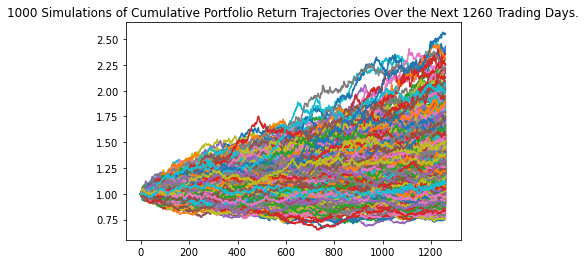

In [29]:
# Plot simulation outcomes
mc_sim_5.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

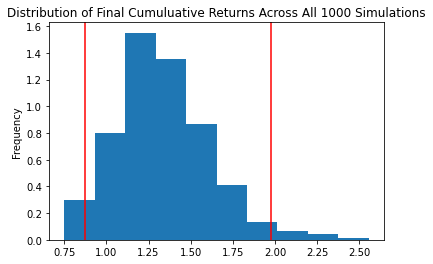

In [30]:
# Plot probability distribution and confidence intervals
mc_sim_5.plot_distribution()

In [43]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_5 = mc_sim_5.summarize_cumulative_return()

# Print summary statistics
summary_5

count           1000.000000
mean               1.335118
std                0.277488
min                0.750875
25%                1.146356
50%                1.304887
75%                1.500271
max                2.555661
95% CI Lower       0.875553
95% CI Upper       1.977055
Name: 1260, dtype: float64

In [44]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
lower_5 = initial_investment*summary_5['95% CI Lower']
upper_5 = initial_investment*summary_5['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower_5:0.2f} and ${upper_5:0.2f}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 30 years will end within in the range of $52533.15 and $118623.27


### Ten Years Retirement Option

In [33]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10 = MCSimulation(portfolio_data = working_data, weights=list(weights.values()), num_simulation=1000, num_trading_days=252*10)

In [34]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_sim_10.calc_cumulative_return()

/Users/stuartperry/Projects/PythonProjects/Fintech/Unit-5-homework/Instructions/Starter_Code/MCForecastTools.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001855,0.993783,0.999015,1.002835,0.998968,0.996179,0.999356,0.999670,0.997601,1.014048,...,0.994888,1.000452,1.005389,1.004340,0.999839,1.007409,0.994894,0.997992,0.993847,1.006622
2,0.993473,1.002042,0.993410,1.003387,1.000004,1.000477,0.992528,1.000239,1.001819,1.020035,...,0.992582,1.004776,0.996624,1.003598,1.004207,1.000432,0.982853,0.998998,1.002778,1.000534
3,0.992861,0.994979,0.998836,1.006570,0.999945,0.993455,0.996862,1.004399,1.006330,1.017089,...,0.996490,0.993639,0.984395,1.007451,0.998918,0.998295,0.980801,1.005919,1.005049,0.996724
4,0.997134,0.988624,0.997270,1.009952,1.001952,0.997086,0.992029,1.003018,1.010652,1.015961,...,0.993738,1.004152,0.978616,1.005816,1.001186,0.990509,0.984118,1.012183,1.004363,0.996968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,2.237334,1.395026,1.870477,3.456821,1.371922,1.816335,2.195363,2.003532,1.997289,1.710581,...,1.200255,1.162563,1.553904,0.875949,1.275316,2.169741,1.927068,2.662433,1.896257,1.887958
2517,2.252805,1.393032,1.861442,3.465196,1.370324,1.820932,2.182370,2.018262,2.019454,1.702518,...,1.190999,1.156287,1.554012,0.875625,1.278104,2.147680,1.920661,2.644261,1.885624,1.870080
2518,2.263541,1.393606,1.847443,3.471056,1.376584,1.809136,2.173688,2.006372,2.018731,1.710422,...,1.199332,1.170896,1.540918,0.873291,1.278241,2.152485,1.917874,2.646502,1.874949,1.863396
2519,2.276296,1.387657,1.857583,3.460501,1.387358,1.800993,2.181951,2.006090,2.028353,1.718054,...,1.190026,1.164780,1.543900,0.880571,1.273221,2.164695,1.935700,2.627225,1.885800,1.871422


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

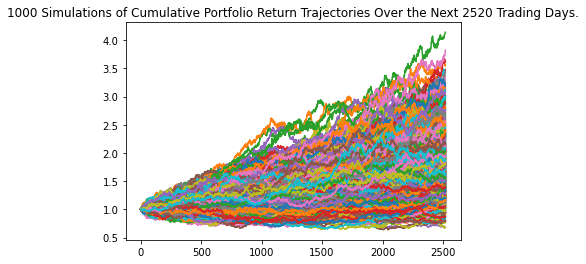

In [36]:
# Plot simulation outcomes
mc_sim_10.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

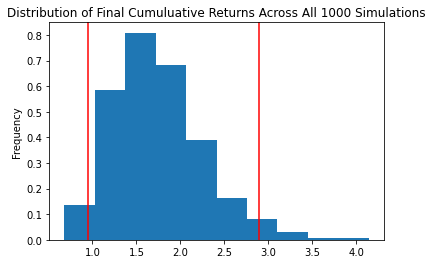

In [37]:
# Plot probability distribution and confidence intervals
mc_sim_10.plot_distribution()

In [39]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_10 = mc_sim_10.summarize_cumulative_return()

# Print summary statistics
summary_10

count           1000.000000
mean               1.738679
std                0.511678
min                0.680017
25%                1.373309
50%                1.681219
75%                2.040888
max                4.141346
95% CI Lower       0.945807
95% CI Upper       2.894145
Name: 2520, dtype: float64

In [41]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
lower_10 = initial_investment*summary_10['95% CI Lower']
upper_10 = initial_investment*summary_10['95% CI Upper']

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${lower_10:0.2f} and ${upper_10:0.2f}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $18916.14 and $57882.90
